# 単語の埋め込み

ディープラーニングが自然言語処理に活用され始める前は、単語を計算可能なベクトルに変換する処理としては、文書集合内の各単語がある文書に出現した場合に1を、そうでない場合は0を出すようなBag of Wordsというものがよく用いられた。これは扱うデータが大きく語彙数が多くなると非常に高次元になるため、特異値分解などで次元削減を行うこともあった。

ディープラーニングが活用されるようになり登場したものが単語の**埋め込み**（embedding）や**分散表現**（distributed representation）と呼ばれるもので、これらは$\{0, 1\}$に限らない値をとり、また次元数を語彙の数よりも小さく（次元圧縮）することもできる（実はニューラルネットワークを使った言語モデルの中間層を埋め込みとするので、それゆえ任意の次元数にできる）。

有名なのはWord2VecやElMoである。両者の大まかな違いとしては、Word2Vecは単語ごとに一意な分散表現になるが、ElMoは文脈によって分散表現が変わるということ。
例えば「彼はスポーツが下手だ」と「彼はいつも下手に出がちだ」は同じ「下手」という語だが意味が異なる。Word2Vecはこのような文脈を考慮しないが、ElMoは考慮する。

## 共起行列

文章$S = (w_1, \dots, w_d)$のある単語$w_i$の周囲の単語の集合（例えば両側$c$個をとって$C=\{ w_{i-c}, \dots, w_{i-1}, w_{i+1}, \dots, w_{i+c} \}$）を**文脈**（context）$C$といい、各単語$w_j (i \neq j)$が$C$に含まれるかどうかを$\{0, 1\}$で表現する。

この関係性を表す行列を**共起行列**（co-occurence matrix）という。

|       | $w_1$ | $w_2$ | $w_3$ | $w_4$ | $w_5$ |
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| $w_3$ |   0   |   1   |   0   |   1   |   0   |


共起行列を特異値分解にかけて単語の分散表現を取得するなどといった方法がニューラルネットワーク登場以前の自然言語処理の主要なアプローチであった


## Word2Vec

文脈をもとに単語を予測するモデルをニューラルネットワークで構築し、中間層の重みベクトルを埋め込みとして使う方法。

```
King - Man + Woman = Queen
```

のような語彙間の類似度や計算が可能な表現


### Word2Vecのアプローチは複数ある

Word2Vecの方法は、

1. CBOW (continuous bag of words)
2. Skip-Gram

の2種類がある。

CBOWはt番目の単語を予測対象にしてその周囲の単語を入力とする。
Skip-gramはt番目の単語を使ってその周囲の単語を予測する

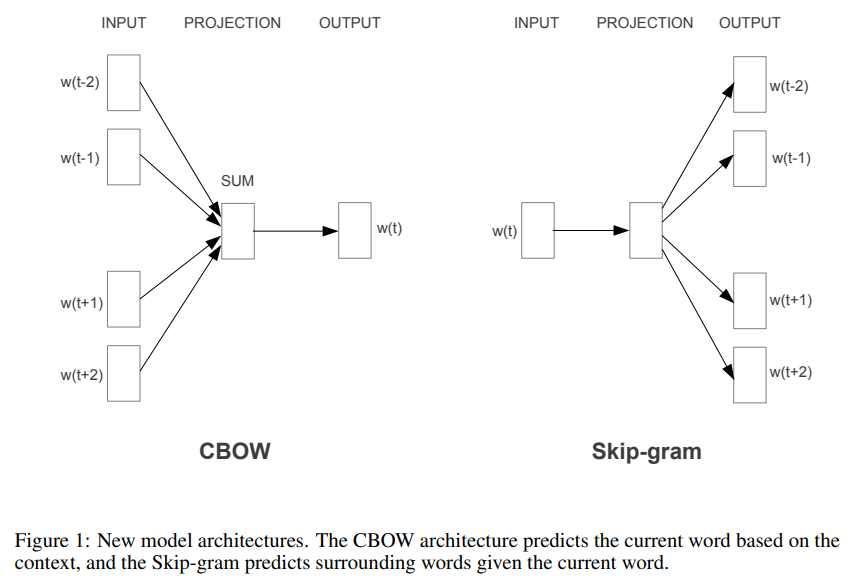

[Mikolov et al. (2013)](https://arxiv.org/pdf/1301.3781.pdf)

### CBOW

**CBOW** (continuous bag of words)モデルは文章$S=(w_1, w_2, \dots, w_n)$が与えられた時、その$i$番目の単語$w_i$を、
その周りの単語である文脈$\boldsymbol{C}_i=(w_{i-c}, \dots, w_{i-1}, w_{i+1}, \dots, w_{i+c})$から予測するモデルである。ここで$c$はウィンドウサイズと呼ばれるハイパーパラメータ。

$$
P(w_i|\boldsymbol{C}_i)
$$


モデルとしては2層の全結合層から成るモデルになる

:::{card} PyTorchのEmbeddingレイヤってなんなの

[Embedding — PyTorch 2.0 documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

one-hot表現のコンテキスト（例えば$c=(0, 1, 0, 0)$）と重み行列との全結合層は、結局のところkey-valueからの取り出しのようなもの。

計算の高速化のために専用のlook-up tableだけの層を作ったほうがいい → Embeddingレイヤになった（ゼロから作るDeep Learning (2) 135ページ）

```python
import numpy as np

# 全結合層による変換のイメージ
np.random.seed(0)
c = np.array([0, 1, 0, 0]) # context（one-hotなので対応する単語のWを取り出す形になる）
n_hidden = 2
W = np.random.randn(len(c), n_hidden)
h = c @ W
print("      h =", h)
print("W[i, :] =", W[np.argmax(c), ])
```

```
      h = [0.97873798 2.2408932 ]
W[i, :] = [0.97873798 2.2408932 ]
```
:::

### PyTorch実装

（参考：[FraLotito/pytorch-continuous-bag-of-words](https://github.com/FraLotito/pytorch-continuous-bag-of-words)）

In [1]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = (
          [raw_text[i - j - 1] for j in range(CONTEXT_SIZE)]
        + [raw_text[i + j + 1] for j in range(CONTEXT_SIZE)]
    )
    target = raw_text[i]
    data.append((context, target))

print(data[:3])

[(['are', 'We', 'to', 'study'], 'about'), (['about', 'are', 'study', 'the'], 'to'), (['to', 'about', 'the', 'idea'], 'study')]


In [2]:
import torch
import torch.nn as nn

def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        # out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)
    

# set model
model = CBOW(vocab_size, embedding_dim=100)
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# training
for epoch in range(50):
    total_loss = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)  

        log_probs = model(context_vector)

        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

# testing
context = ['People','create', 'to', 'direct']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)

# result
print(f'Raw text: {" ".join(raw_text)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

Raw text: We are about to study the idea of a computational process. Computational processes are abstract beings that inhabit computers. As they evolve, processes manipulate other abstract things called data. The evolution of a process is directed by a pattern of rules called a program. People create programs to direct processes. In effect, we conjure the spirits of the computer with our spells.

Context: ['People', 'create', 'to', 'direct']

Prediction: programs


In [3]:
model.get_word_emdedding("programs")

tensor([[ 0.5434,  0.2332,  0.7662, -0.4796, -0.1528, -1.4136, -0.5756,  0.9351,
          0.6670,  0.9162, -0.5905,  0.5579, -0.0178,  0.3593,  2.2713,  0.1769,
          0.4689, -0.3956, -0.3189,  1.5565,  0.0640,  2.0463,  1.0004, -1.9602,
         -0.1542, -0.5535,  1.3421, -1.7766, -0.6081,  0.9056,  2.7304,  0.0404,
          1.6364,  0.5478,  0.2529, -0.2505, -0.6349, -0.1685, -1.2054,  0.3111,
          0.7322,  0.1215,  0.2398,  1.2386,  0.9335,  1.9055, -0.8145, -0.2150,
          0.1801,  0.5118,  1.0085,  0.1413,  1.5495,  1.7253, -0.2457, -0.1325,
          2.4090, -0.6194, -0.1996, -0.9564,  0.1325,  0.8500,  0.5511,  0.9474,
         -0.7217,  1.4874, -0.6126, -0.5200, -0.2816, -1.2148,  1.1512, -0.4726,
          1.6923,  0.0481,  0.2111, -0.0350,  0.1111,  0.6029,  0.2105,  0.4399,
         -1.3693,  1.2838,  1.0333, -0.8562,  0.3680, -0.7780, -0.9584, -0.7385,
         -0.8830, -2.0993,  0.5276, -1.7945, -0.2172, -0.7706, -0.3773, -1.4444,
         -0.1156, -1.7405, -

### Skip-Gram

単語から文脈を予測するモデル$P(\boldsymbol{C}_i|w_i)$を使って単語の分散表現を得る方法。


訓練データの単語$w_1,w_2,\dots,w_T$のもとで、確率の対数の平均を最大化するのが目的

$$
\frac{1}{T}
\sum^T_{t=1}
\sum_{-c\leq j \leq c, j \neq 0}
\log p(w_{t+j} | w_t)
$$

確率はsoftmaxで計算される

$$
p(w_O|w_I) = \frac{\exp( v_{w_O}^T v_{w_I} )}{\sum^W_{w=1} \exp( v_{w}^T v_{w_I} ) }
$$

ここで$W$は語彙数、$v$は単語のベクトル表現。$\nabla \log p(w_O|w_I)$は$W$に比例し、計算不可能なオーダー（$10^7$とか）になりうるので計算量の削減の工夫が必要になる

#### 計算量の問題

Skip-Gramはそのままでは計算量が多すぎるので対策がとられる（[Mikolov et al., 2013](https://arxiv.org/pdf/1310.4546.pdf)）

1. Hierarchical Softmax：二分木探索のように探索範囲を絞るっぽい
2. Noise Constrastive Estimation
3. Negative Sampling：多値分類（$w_i$はどの単語か）を二値分類（$w_i$は"woman"か）に近似する + 負例はランダムサンプリングする。

### CBOWとSkip-Gramのどちらがよいか

精度がいいのはSkip-gramらしい



## gensimによるWord2Vecの実行

https://radimrehurek.com/gensim/models/word2vec.html

In [4]:
# トークンに分割した文章の集合の例
sentences = [
    ["king", "male", "ruler"],
    ["queen", "female", "ruler"],
    ["man", "male"],
    ["woman", "female"],
]

from gensim.models import Word2Vec
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

In [5]:
# kingに意味が近い上位3個（similarの基準はコサイン類似度）
sims = model.wv.most_similar('king', topn=3)
sims

[('male', 0.1459505707025528),
 ('woman', 0.041577354073524475),
 ('man', 0.03476494178175926)]

In [6]:
# king + woman - man ≒ queen というアレ
model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

[('queen', 0.0066775488667190075)]

In [7]:
# 自前で足し引きして類似度計算してみる
import numpy as np
def cosine_sim(a, b):
    return a @ b / (np.linalg.norm(a) * np.linalg.norm(b))

v = model.wv["king"] - model.wv["man"] + model.wv["woman"]
words = set(sum(sentences, [])) - {"king", "man", "woman"} # 計算に使ったものは必然的に類似度が高くなっちゃうので除く
for word in words:
    print(f"{word}: {cosine_sim(v, model.wv[word]):.3g}")

# queenが一番近くなった

female: -0.0395
ruler: -0.0263
male: -0.0251
queen: 0.00656


## GloVe

CBOWとは違ったモデルでの埋め込み表現の獲得を行う

- website: [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)
- Rのtext2vecパッケージの解説記事: [GloVe Word Embeddings](http://text2vec.org/glove.html#glove_algorithm)


## 参考文献

- https://code.google.com/archive/p/word2vec/
- [Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.](https://arxiv.org/pdf/1301.3781.pdf)
- [[1310.4546] Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/abs/1310.4546)